In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline
import torchvision.transforms as T

from utils import preprocess, recover_image

/mnt/ssd1/micromamba/envs/ndf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
to_pil = T.ToPILImage()

### First lets instantiate a stable diffusion model

In [3]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

import torch

model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe_img2img = pipe.to("cuda")
# model_id_or_path = "CompVis/stable-diffusion-v1-4"
# model_id_or_path = "CompVis/stable-diffusion-v1-3"
# model_id_or_path = "CompVis/stable-diffusion-v1-2"
# model_id_or_path = "CompVis/stable-diffusion-v1-1"


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


### Now let's get any image from the internet and resize it properly

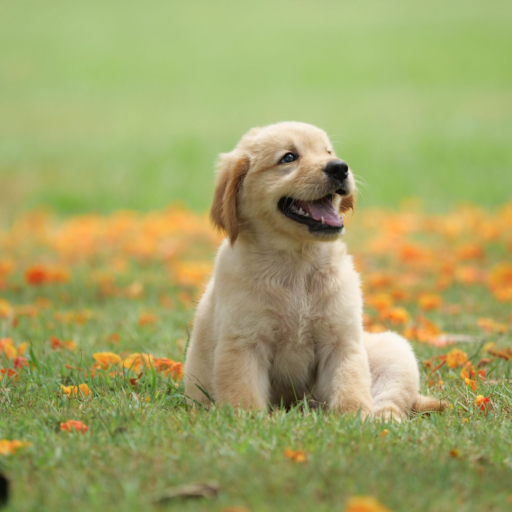

In [4]:
url = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
resize = T.transforms.Resize(512)
center_crop = T.transforms.CenterCrop(512)
init_image = center_crop(resize(init_image))
init_image

### Simple attack implementation
Now we implement a simple PGD attack 

In [5]:
def pgd(X, model, eps=0.1, step_size=0.015, iters=40, clamp_min=0, clamp_max=1, mask=None):
    X_adv = X.clone().detach() + (torch.rand(*X.shape)*2*eps-eps).cuda()
    pbar = tqdm(range(iters))
    for i in pbar:
        actual_step_size = step_size - (step_size - step_size / 100) / iters * i  

        X_adv.requires_grad_(True)

        loss = (model(X_adv).latent_dist.mean).norm()

        pbar.set_description(f"[Running attack]: Loss {loss.item():.5f} | step size: {actual_step_size:.4}")

        grad, = torch.autograd.grad(loss, [X_adv])
        
        X_adv = X_adv - grad.detach().sign() * actual_step_size
        X_adv = torch.minimum(torch.maximum(X_adv, X - eps), X + eps)
        X_adv.data = torch.clamp(X_adv, min=clamp_min, max=clamp_max)
        X_adv.grad = None    
        
        if mask is not None:
            X_adv.data *= mask
            
    return X_adv



### Executing the attack
Now we apply the attack to our image

In [6]:
# You may want to play with the parameters of the attack to get stronger attacks, but we found the below params to be decent for our demo

with torch.autocast('cuda'):
    X = preprocess(init_image).half().cuda()
    adv_X = pgd(X, 
                model=pipe_img2img.vae.encode, 
                clamp_min=-1, 
                clamp_max=1,
                eps=0.06, # The higher, the less imperceptible the attack is 
                step_size=0.02, # Set smaller than eps
                iters=1000, # The higher, the stronger your attack will be
               )
    
    # convert pixels back to [0,1] range
    adv_X = (adv_X / 2 + 0.5).clamp(0, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

[Running attack]: Loss 170.24948 | step size: 0.0002198: 100%|██████████| 1000/1000 [01:29<00:00, 11.15it/s]


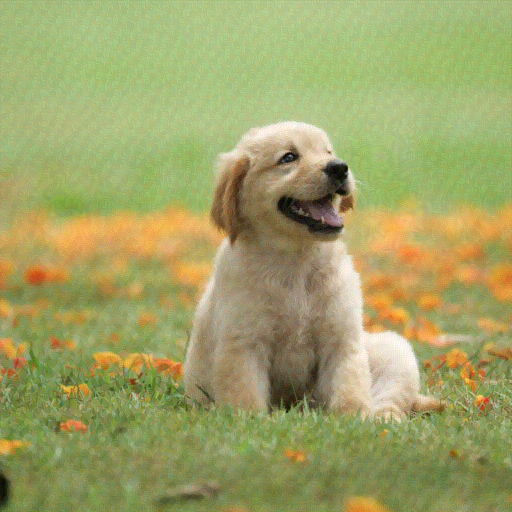

In [7]:
adv_image = to_pil(adv_X[0]).convert("RGB")
adv_image

### Running Stable Diffusion
Now that we generated an "immunized"/adversarial image, lets try to run stable diffusion on both the original and the adversarial images

In [8]:
prompt = "a faory in the forest"

# a good seed (uncomment the line below to generate new images)
SEED = 9222
# SEED = np.random.randint(low=0, high=10000)

# Play with these for improving generated image quality
STRENGTH = 0.5
GUIDANCE = 7.5
NUM_STEPS = 50

with torch.autocast('cuda'):
    torch.manual_seed(SEED)
    image_nat = pipe_img2img(prompt=prompt, image=init_image, strength=STRENGTH, guidance_scale=GUIDANCE, num_inference_steps=NUM_STEPS).images[0]
    torch.manual_seed(SEED)
    image_adv = pipe_img2img(prompt=prompt, image=adv_image, strength=STRENGTH, guidance_scale=GUIDANCE, num_inference_steps=NUM_STEPS).images[0]

100%|██████████| 25/25 [00:01<00:00, 16.07it/s]


### Putting all results together
As you can see below, althouth the adversarial image and the source image look almost the same, their generated results are totally different! Specifically, the generated image from the adversarial image does not resemble the original image at all. This signifies that our attack is successful, and the stable diffusion model is not relying on the source imge during generation.

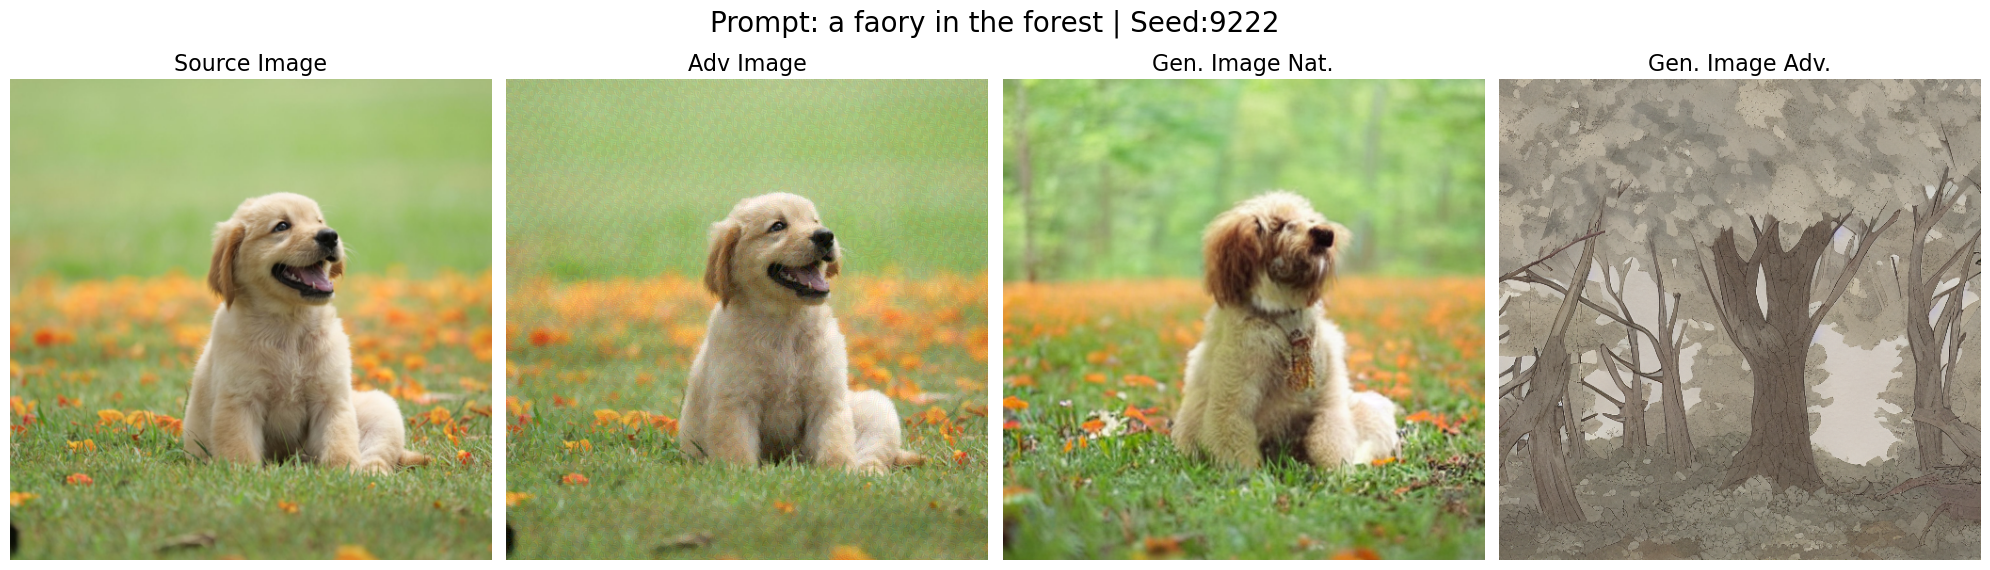

In [9]:
# adv_image = recover_image(adv_image, init_image, mask_image, background=True)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

ax[0].imshow(init_image)
ax[1].imshow(adv_image)
ax[2].imshow(image_nat)
ax[3].imshow(image_adv)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Adv Image', fontsize=16)
ax[2].set_title('Gen. Image Nat.', fontsize=16)
ax[3].set_title('Gen. Image Adv.', fontsize=16)

for i in range(4):
    ax[i].grid(False)
    ax[i].axis('off')
    
fig.suptitle(f"Prompt: {prompt} | Seed:{SEED}", fontsize=20)
fig.tight_layout()
plt.show()

# OmnAI Team


In [10]:
import sys

sys.path.append("/mnt/ssd2/hazem/Projects/No-deepfakable/no-deepfakable/files")
sys.path.append("/mnt/ssd2/hazem/Projects/No-deepfakable/no-deepfakable")

from files.stableIm2Im_image_anchor import Im2Im

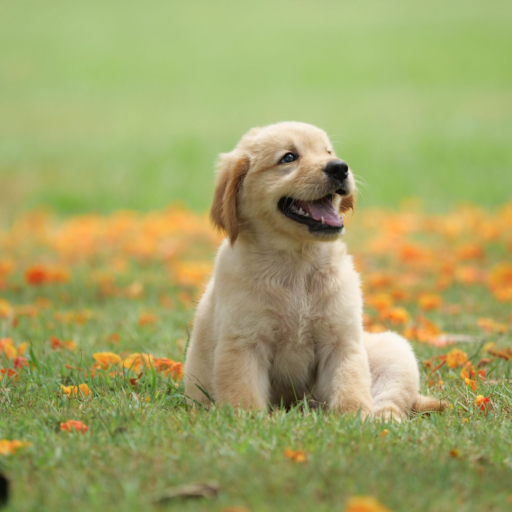

In [11]:
url = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
resize = T.transforms.Resize(512)
center_crop = T.transforms.CenterCrop(512)
init_image = center_crop(resize(init_image))
init_image

In [12]:
with torch.autocast("cuda"):
    torch.manual_seed(SEED)
    image_nat = (
        StableDiffusionImg2ImgPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
        )
        .to("cuda:0")(
            prompt=prompt,
            image=init_image,
            strength=0.5,
            guidance_scale=7.5,
            num_inference_steps=50,
        )
        .images[0]
    )

100%|██████████| 25/25 [00:01<00:00, 16.12it/s]


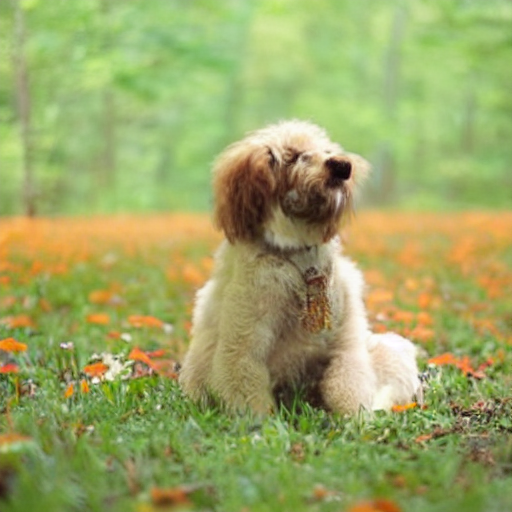

In [13]:
image_nat

In [14]:
############## Attack Image Generation ################
from files.stableIm2Im_image_anchor import Im2Im
pipe_img2img = Im2Im.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe_img2img = pipe_img2img.to("cuda:0")


with torch.autocast("cuda"):
    torch.manual_seed(SEED)
    image_attack, _ = pipe_img2img(
        prompt=prompt,
        image=init_image,
        image_target=init_image,
        strength=0.5,
        guidance_scale=7.5,
        num_inference_steps=50,
        attack=True,
        return_dict=False,
        reference_traj=None,  # "/home/briglia/basefolder/photoguard-main/demo/images/adv_predictions.pkl",
    )

    # if type format is numpy converto to PIL
if isinstance(image_attack, torch.Tensor):
    image_attack = to_pil(image_attack)
if isinstance(image_attack, np.ndarray):
    # the array is (s,s,3) so we need to convert it to (3,s,s)
    image_attack = np.transpose(image_attack, (2, 0, 1))
    image_attack = torch.tensor(image_attack)
    image_attack = to_pil(image_attack)
    del pipe_img2img


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]



 1. Crafting the adversarial trajectory 



Step 25 of 25: 100%|██████████| 26/26 [00:09<00:00,  2.83it/s]



2. Optimize the gamma offset to the initial noisy latent 



Loss: 1.616455078125: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]   


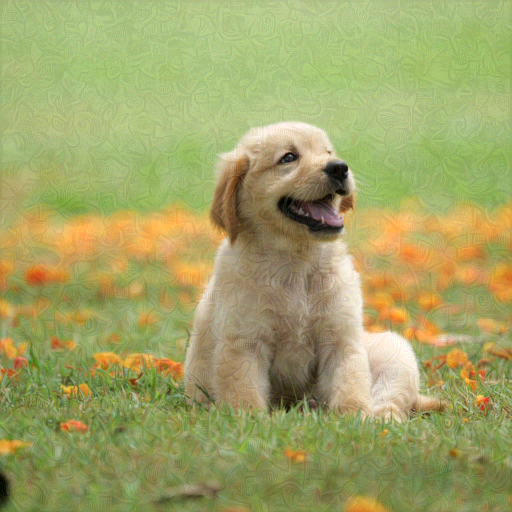

In [15]:
image_attack


In [16]:
with torch.autocast("cuda"):
    torch.manual_seed(SEED)
    image_corr = (
        StableDiffusionImg2ImgPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
        )
        .to("cuda:0")(
            prompt=prompt,
            image=image_attack,
            strength=0.5,
            guidance_scale=7.5,
            num_inference_steps=50,
        )
        .images[0]
    )

100%|██████████| 25/25 [00:01<00:00, 16.19it/s]


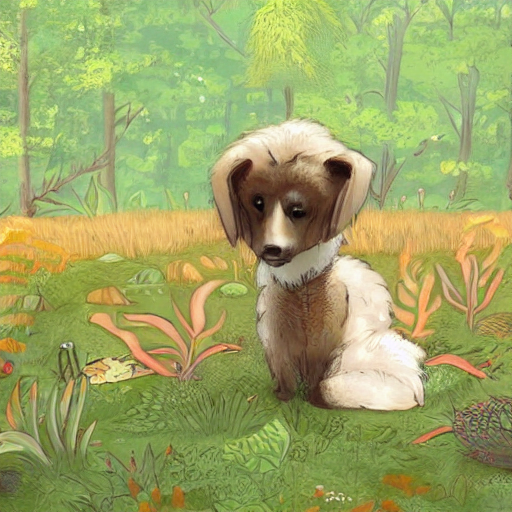

In [17]:
image_corr

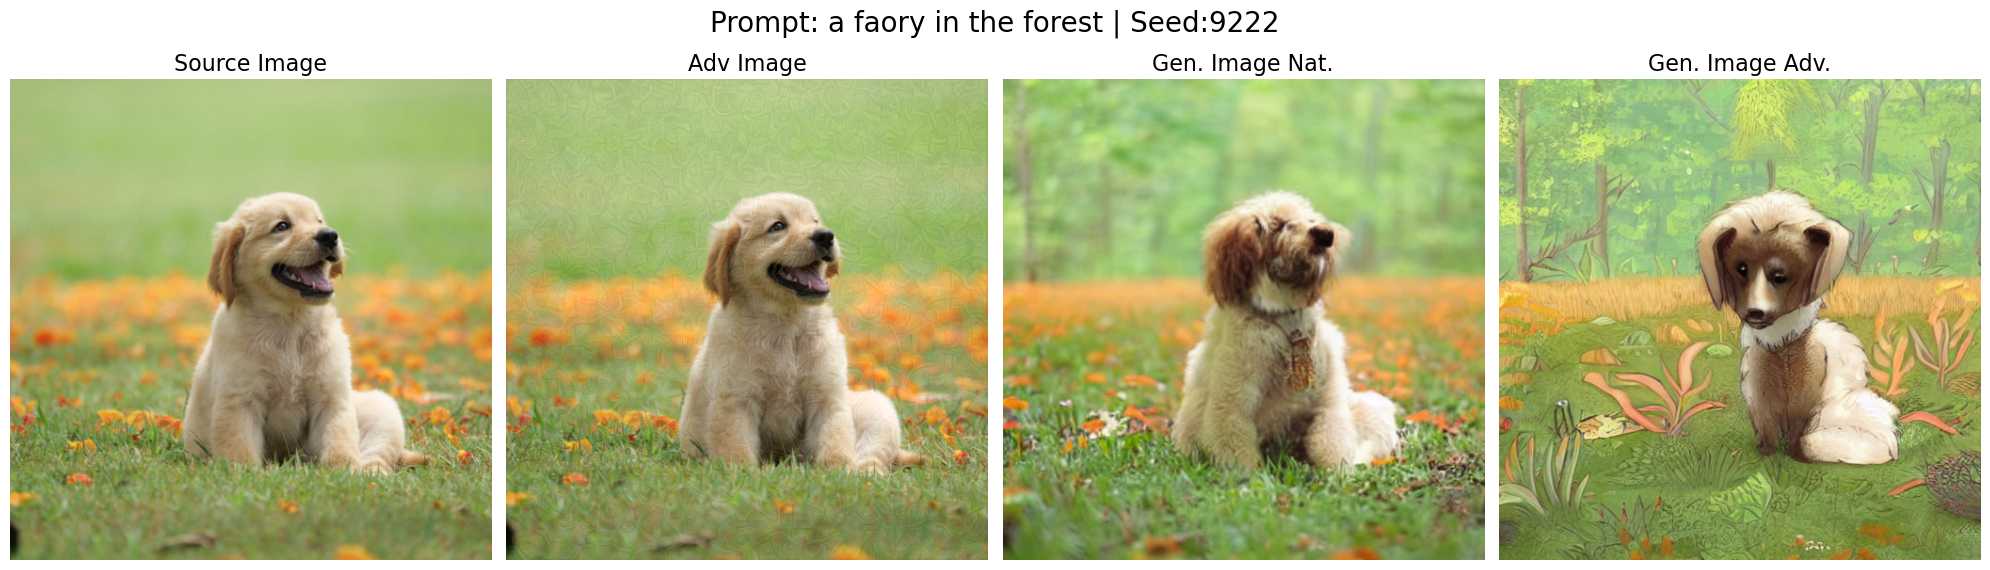

In [18]:
# adv_image = recover_image(adv_image, init_image, mask_image, background=True)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

ax[0].imshow(init_image)
ax[1].imshow(image_attack)
ax[2].imshow(image_nat)
ax[3].imshow(image_corr)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Adv Image', fontsize=16)
ax[2].set_title('Gen. Image Nat.', fontsize=16)
ax[3].set_title('Gen. Image Adv.', fontsize=16)

for i in range(4):
    ax[i].grid(False)
    ax[i].axis('off')
    
fig.suptitle(f"Prompt: {prompt} | Seed:{SEED}", fontsize=20)
fig.tight_layout()
plt.show()